# Train With Colbert

In [ ]:
import os
import glob
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Optional, Union
from scipy.special import softmax
from pathlib import Path

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries
from colbert import Indexer, Searcher

import wandb
import torch
import evaluate
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, TrainingArguments, \
                         IntervalStrategy, get_linear_schedule_with_warmup
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers.utils.notebook import NotebookProgressCallback
from datasets import Dataset # HuggingFace
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
pl.Config(fmt_str_lengths=2000);

In [3]:
#!conda install -c conda-forge faiss-gpu -y

In [4]:
dfs = []
folder_path = './data/daniel_train/v_1/*'
columns = ['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4', 'title', 'section_title']

for csv_file in glob.glob(folder_path):
    df = pl.read_csv(csv_file)
    dfs.append(df[columns])

train_raw = pl.concat(dfs)\
              .filter(pl.col('question').is_not_null())
train_raw.shape, np.array(train_raw.columns)

((6374, 8),
 array(['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3',
        'incorrect_4', 'title', 'section_title'], dtype='<U13'))

In [5]:
# train_raw.write_parquet('./data/daniel_train/v_1_combined/daniel_train_v_1.parquet')

In [6]:
choices_np = train_raw[['correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4']].to_numpy()

n_rows, n_cols = choices_np.shape
shuffled_indices = np.array([np.random.permutation(n_cols) for _ in range(n_rows)])
shuffled_data = np.take_along_axis(choices_np, shuffled_indices, axis=1)
correct_positions = np.argmax(shuffled_data == choices_np[:, 0][:, np.newaxis], axis=1)

answer_map = np.array(['A', 'B', 'C', 'D', 'E'])
answers = answer_map[correct_positions]

choices = pl.DataFrame({
    'A': shuffled_data[:, 0].astype(str),
    'B': shuffled_data[:, 1].astype(str),
    'C': shuffled_data[:, 2].astype(str),
    'D': shuffled_data[:, 3].astype(str),
    'E': shuffled_data[:, 4].astype(str),
    'answer': answers
    },
    [(col, pl.Utf8) for col in ['A', 'B', 'C', 'D', 'E', 'answer']]
)

train = train_raw[['question','title', 'section_title']].with_columns(choices)

n_test2 = 500
test2 = train[train.shape[0] - n_test2:]
train = train[:train.shape[0] - n_test2]
print(train.shape[0], test2.shape[0])

5874 500


In [7]:
train_osmu = pl.read_csv('./data/6000_wiki_en_sci_questions_with_excerpts.csv') \
               .filter(pl.col('A').is_not_null())
train_osmu = train_osmu.rename({'prompt': 'question'})

test_osmu = train_osmu[train_osmu.shape[0]- n_test2:]
train_osmu = train_osmu[:train_osmu.shape[0]- n_test2]
train_osmu.shape, test_osmu.shape, train_osmu.columns

((5518, 8),
 (500, 8),
 ['question', 'A', 'C', 'B', 'D', 'E', 'answer', 'wikipedia_excerpt'])

In [8]:
test = pl.read_csv('data/train.csv')
test = test.rename({'prompt': 'question'})
test = test.drop(columns="id")
test.columns

['question', 'A', 'B', 'C', 'D', 'E', 'answer']

## Retrieve Wiki Context via ColBERT

In [1]:
max_words = 140
wiki_passages = pl.read_parquet(f'./data/colbert-{max_words}-v3/wiki_passages_{max_words}.parquet')
wiki_passages.columns

NameError: name 'pl' is not defined

In [10]:
word_counts = wiki_passages['passage_text'].str.split(' ').list.lengths()
assert max_words == word_counts.max()
word_counts.max(), wiki_passages['title'].n_unique()

(140, 47436)

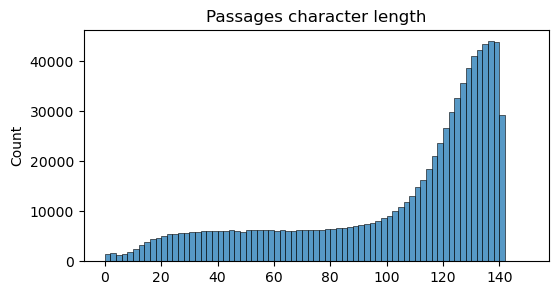

In [11]:
plt.figure(figsize=[6,3])
sns.histplot(word_counts, binrange=[0, 150], bins=75)
plt.title('Passages character length');

In [12]:
n_results_per_question = 3

nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 512   # lenght in tokens
dim = 128 # 128 is max for BERT

wiki_passages = pl.read_parquet(f'./data/colbert-{max_words}-v3/wiki_passages_{max_words}.parquet')
wiki_passages.columns

checkpoint = './checkpoints/colbertv2.0'
indexer_name = f"wiki_pages_index_{nbits}bits_max_words{max_words}"
#os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

config = ColBERTConfig(
    doc_maxlen=doc_maxlen,
    nbits=nbits,
    dim=dim
)

In [13]:
train.columns

['question', 'title', 'section_title', 'A', 'B', 'C', 'D', 'E', 'answer']

In [17]:
def add_q_colbert_context(data):
    num_ctx_cols = 2
    queries = data.with_row_count('qid')[['qid', 'question']]
    queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
    queries_file = './data/wiki_queries.tsv'
    queries.write_csv(queries_file, separator='\t', has_header=False)

    c_queries = Queries(queries_file)

    with Run().context(RunConfig(nranks=1, 
                                 index_root=f'./data/colbert-{max_words}-v3')):
        searcher = Searcher(index=indexer_name,
                            config=config,
                            collection=f'./data/colbert-140-v3/wiki_passages_{max_words}.tsv')
        ranking = searcher.search_all(c_queries, k=n_results_per_question)

    colbert_passage_ids = pl.DataFrame(pd.DataFrame(ranking.items()))
    colbert_passage_ids = colbert_passage_ids \
        .lazy() \
        .select([pl.col("1").list.get(i).list.get(0).alias(f"wiki_ctx_{i+1}").cast(pl.UInt32) for i in range(num_ctx_cols)]) \
        .collect()
    
    passages = wiki_passages[['passage_id', 'passage_text']]
    data_p = data.with_columns(colbert_passage_ids)
    for i in range(num_ctx_cols):
        data_p = data_p.join(passages, how='left', left_on=f'wiki_ctx_{i+1}', right_on='passage_id', validate='m:1', suffix=f'_{i+1}')
    return data_p

In [18]:
rerun = True

train_p_path = Path(f'./data/train_daniel_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')
train_osmu_p_path = Path(f'./data/train_osmu_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')
test_p_path = Path(f'./data/test_daniel_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')
test2_p_path = Path(f'./data/test2_daniel_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')
test_osmu_p_path = Path(f'./data/test2_osmu_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')

def cached_add_q_colbert_context(data, cache_path):
    if cache_path.exists() and not rerun:
        return pl.read_parquet(cache_path)
    else:
        with_context = add_q_colbert_context(data)
        torch.cuda.empty_cache()
        with_context.write_parquet(cache_path)
        return with_context
    
train_p = cached_add_q_colbert_context(train, train_p_path)
train_osmu_p = cached_add_q_colbert_context(train_osmu, train_osmu_p_path)
test_p = cached_add_q_colbert_context(test, test_p_path)
test2_p = cached_add_q_colbert_context(test2, test2_p_path)
test_osmu_p = cached_add_q_colbert_context(test_osmu, test_osmu_p_path)

[Sep 10, 14:17:26] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 10, 14:17:26] #> Got 5874 queries. All QIDs are unique.

[Sep 10, 14:17:26] #> Loading collection...
0M 
[Sep 10, 14:17:28] #> Loading codec...
[Sep 10, 14:17:28] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Sep 10, 14:17:28] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Sep 10, 14:17:28] #> Loading IVF...
[Sep 10, 14:17:28] #> Loading doclens...


100%|██████████| 34/34 [00:00<00:00, 3192.66it/s]

[Sep 10, 14:17:28] #> Loading codes and residuals...



100%|██████████| 5874/5874 [00:24<00:00, 236.18it/s]


[Sep 10, 14:17:55] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 10, 14:17:55] #> Got 5518 queries. All QIDs are unique.

[Sep 10, 14:17:55] #> Loading collection...
0M 
[Sep 10, 14:17:57] #> Loading codec...
[Sep 10, 14:17:57] #> Loading IVF...
[Sep 10, 14:17:57] #> Loading doclens...


100%|██████████| 34/34 [00:00<00:00, 3247.62it/s]

[Sep 10, 14:17:57] #> Loading codes and residuals...



100%|██████████| 5518/5518 [00:26<00:00, 206.24it/s]


[Sep 10, 14:18:26] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 10, 14:18:26] #> Got 200 queries. All QIDs are unique.

[Sep 10, 14:18:26] #> Loading collection...
0M 
[Sep 10, 14:18:27] #> Loading codec...
[Sep 10, 14:18:27] #> Loading IVF...
[Sep 10, 14:18:27] #> Loading doclens...


100%|██████████| 34/34 [00:00<00:00, 3187.16it/s]

[Sep 10, 14:18:27] #> Loading codes and residuals...



100%|██████████| 200/200 [00:00<00:00, 215.06it/s]


[Sep 10, 14:18:30] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 10, 14:18:30] #> Got 500 queries. All QIDs are unique.

[Sep 10, 14:18:30] #> Loading collection...
0M 
[Sep 10, 14:18:32] #> Loading codec...
[Sep 10, 14:18:32] #> Loading IVF...
[Sep 10, 14:18:32] #> Loading doclens...


100%|██████████| 34/34 [00:00<00:00, 2853.04it/s]

[Sep 10, 14:18:32] #> Loading codes and residuals...



100%|██████████| 500/500 [00:02<00:00, 218.28it/s]


[Sep 10, 14:18:35] #> Loading the queries from ./data/wiki_queries.tsv ...
[Sep 10, 14:18:35] #> Got 500 queries. All QIDs are unique.

[Sep 10, 14:18:35] #> Loading collection...
0M 
[Sep 10, 14:18:37] #> Loading codec...
[Sep 10, 14:18:37] #> Loading IVF...
[Sep 10, 14:18:37] #> Loading doclens...


100%|██████████| 34/34 [00:00<00:00, 2853.78it/s]

[Sep 10, 14:18:37] #> Loading codes and residuals...



100%|██████████| 500/500 [00:02<00:00, 194.47it/s]


In [21]:
# test_osmu_p['passage_text'].str.split(' ').list.lengths().max()

## Prepare Train and Test for DeBERTa

In [19]:
deberta_v3_large = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
max_length = 625

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None

    
    def __call__(self, input_batch):
        # input_batch is list of samples, choices, tokens
        additional_cols = set(input_batch[0].keys()) - set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        if len(additional_cols) > 0:
            print(f'{additional_cols=}')
        
        label_name = None
        if 'label' in input_batch[0].keys():
            label_name = 'label' 
            labels = [feature.pop(label_name) for feature in input_batch]
        batch_size = len(input_batch)
        num_choices = len(input_batch[0]['input_ids'])
        flattened_input = [
            [{k: v[i] for k, v in sample.items()} for i in range(num_choices)] for sample in input_batch
        ]
        flattened_input = sum(flattened_input, [])
        
        batch = self.tokenizer.pad(
            flattened_input,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors='pt',
        )
        
        # batch.shape = (n_samples, n_choices, n_tokens)
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        if label_name is not None:
            batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        #print(np.array(batch['input_ids']).shape)
        return batch

In [21]:
def preprocess(example):
    # adding the wikipedia page as context for the question by adding it after a [SEP] token to the question.
    first_sentence = [f"""{example['question']}
[SEP]{example['passage_text']}
[SEP]{example['passage_text_2']}
"""] * 5
    second_sentences = [example[option] for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, truncation='only_first', max_length=max_length)
    if 'answer' in example.keys():
        tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

def tokenized_dataset(data):
    columns_to_keep = set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
    dataset = Dataset.from_pandas(data.to_pandas(), preserve_index=False)
    col_to_remove = set(data.columns) - columns_to_keep
    tokenized = dataset.map(preprocess, remove_columns=col_to_remove)
    return tokenized

In [22]:
tokenized_train = tokenized_dataset(train_p)
tokenized_train_osmu = tokenized_dataset(train_osmu_p)
tokenized_test = tokenized_dataset(test_p)
tokenized_test2 = tokenized_dataset(test2_p)
tokenized_test_osmu = tokenized_dataset(test_osmu_p)

cols = ['question', 'A', 'B', 'C', 'D', 'E', 'answer', 'passage_text', 'passage_text_2']
train_comb = pl.concat([
    train_p[cols],
    train_osmu_p[cols]
])
tokenized_train_comb = tokenized_dataset(train_comb)

Map:   0%|          | 0/5874 [00:00<?, ? examples/s]

Map:   0%|          | 0/5518 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/11392 [00:00<?, ? examples/s]

In [26]:
# def plot_length_hist(tokenized_data):
#     length_list = []
#     for sample in tokenized_data['input_ids']:
#         for option in sample:
#             length_list.append(len(option))

#     plt.figure(figsize=[6,3])
#     pd.Series(length_list).hist(bins=100)
    
# plot_length_hist(tokenized_train)
# plot_length_hist(tokenized_train_osmu)

## Train DeBERTa

In [23]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [24]:
retrain = True

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    learning_rate=4e-6,
    num_train_epochs=2,
    #fp16=True,
    #warmup_ratio=0.5,
    weight_decay=0.0,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=100,
    eval_steps=2000,
    save_steps=5000,
    report_to='wandb',
    output_dir=str(output_path),
    run_name='combined_colbert'
)

if not output_path.exists() or retrain:
    model = AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)
    
    # embedding_lr = 1e-8
    # early_layers_lr = 1e-7
    # middle_layers_lr = 1e-6
    # late_layers_lr = 2e-5
    # classifier_lr = 5e-5

#     optimizer_grouped_parameters = [
#         {'params': model.deberta.embeddings.parameters(), 'lr': embedding_lr},
#         {'params': model.deberta.encoder.layer[:8].parameters(), 'lr': early_layers_lr},
#         {'params': model.deberta.encoder.layer[8:16].parameters(), 'lr': middle_layers_lr},
#         {'params': model.deberta.encoder.layer[16:].parameters(), 'lr': late_layers_lr},
#         {'params': model.classifier.parameters(), 'lr': classifier_lr},
#     ]
    optimizer = AdamW(model.parameters(),
                      lr=training_args.learning_rate,
                      weight_decay=training_args.weight_decay)
                      #optimizer_grouped_parameters)
    
    total_steps = len(tokenized_train_comb) // training_args.per_device_train_batch_size * training_args.num_train_epochs
    #warmup_steps = int(total_steps * training_args.warmup_ratio)
    #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    scheduler = OneCycleLR(optimizer, max_lr=training_args.learning_rate, total_steps=total_steps)
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
        train_dataset=tokenized_train_comb,
        eval_dataset={
            'test': tokenized_test,
            'test_daniel': tokenized_test2,
            'test_osmu': tokenized_test_osmu
        },
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )

    # needed when there are multiple eval datasets
    trainer.remove_callback(NotebookProgressCallback)
    trainer.train()
    wandb.finish()
    trainer.save_model(output_path/training_args.run_name)
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/training_args.run_name)

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: datadan. Use `wandb login --relogin` to force relogin


You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max len

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/test_accuracy,▁▆▇█▇▇█████
eval/test_daniel_accuracy,▁▆▇▇███████
eval/test_daniel_loss,█▂▁▁▂▁▃▂▂▂▂
eval/test_daniel_map_at_3,▁▆▇█▇██████
eval/test_daniel_runtime,█▃▂▂▁▃▁▂▂▃▂
eval/test_daniel_samples_per_second,▁▆▇▇█▆▇▇▇▆▇
eval/test_daniel_steps_per_second,▁▇▇▇█▇█▇▇▆█
eval/test_loss,█▃▁▁▂▁▃▃▃▂▃
eval/test_map_at_3,▁▆▇██▇█████
eval/test_osmu_accuracy,▁▅▆▇▇█▇▇███
eval/test_osmu_loss,▂▂▃▁▅▂█▇▇▆▆


## Predict Test Set

In [36]:
trainer = Trainer(
    model=model,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
)

In [68]:
def predict_testset(test_with_passages, tokenized_testset):
    test_logits = trainer.predict(tokenized_testset).predictions
    test_preds = np.argsort(-test_logits, 1)
    test_letters = np.array(list('ABCDE'))[test_preds]
    test_letters = pl.Series(test_letters[:,:3]).list.join(' ')

    return test_with_passages.with_columns(all_prediction=test_letters, prediction=test_letters.str.slice(0,1))
    
test_pred = predict_testset(test_p, tokenized_test)

/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [38]:
test_osmu_pred = predict_testset(test_osmu_p, tokenized_test_osmu)

In [63]:
wiki_passages.filter(pl.col('title') == 'Mycobacterium madagascariense')

passage_id,section_id,title,section_title,passage_text
u32,u32,str,str,str


### Osmu data notes
0. Based on the wikipedia_excerpt, the wrong answer is marked as correct. Wrong context is provided by Colbert.
1. chloroformic acid and formic acid: Wrong context, though the context was in the wiki passages.
2. interosseous muscles of the hand: context is unspecific, asnwer correct
3. context and answer correct
4. Star Lambda Ceti: Context missing, answer correct ----> add stars to wiki context
5. relativistic rapidity and velocity: correct answer and context
6. decision problem: context and answer correct
7. trilostane in veterinary care: 2nd context and answer correct
8. RSA cryptosystem  and nth root: context missing, answer logically inverted
9. Mycobacterium madagascariense: context missing, wrong answer

In [64]:
test_osmu_pred[8]

question,A,C,B,D,E,answer,wikipedia_excerpt,passage_text,passage_text_2,all_prediction,prediction
str,str,str,str,str,str,str,str,str,str,str,str
"""What would be the consequence if an efficient method for finding the eth roots of an arbitrary number, modulo N, in an RSA cryptosystem is developed?""","""It would depend on the specific factors of the composite number N.""","""It would improve the efficiency of RSA-based cryptosystems without affecting their security.""","""It would increase the security of RSA-based cryptosystems, making them harder to crack.""","""It would have no impact on the security of RSA-based cryptosystems.""","""It would decrease the security of RSA-based cryptosystems, making them easier to crack.""","""E""","""RSA problem: In cryptography, the RSA problem summarizes the task of performing an RSA private-key operation given only the public key The RSA algorithm raises a message to an exponent, modulo a composite number N whose factors are not known Thus, the task can be neatly described as finding the eth roots of an arbitrary number, modulo N For large RSA key sizes (in excess of 1024 bits), no efficient method for solving this problem is known; if an efficient method is ever developed, it would threaten the current or eventual security of RSA-based cryptosystems—both for public-key encryption and digital signatures""","""Let SR(n) be the sum of all the mvarnth roots of unity, primitive or not. Then This is an immediate consequence of Vieta's formulas. In fact, the mvarnth roots of unity being the roots of the polynomial Xn – 1, their sum is the coefficient of degree n – 1, which is either 1 or 0 according whether n = 1 or n > 1. Alternatively, for n = 1 there is nothing to prove, and for n > 1 there exists a root z ≠ 1 – since the set S of all the mvarnth roots of unity is a group (mathematics), zspacehairS = S, so the sum satisfies z SR(n) = SR(n), whence SR(n) = 0. Let SP(n) be the sum of all the primitive mvarnth roots of unity.""","""This algorithm works also over a field of characteristic (algebra) zero, with the only difference that it never enters in the blocks of instructions where pth roots are computed. However, in this case, Square-free polynomial#Yun's algorithm is much more efficient because it computes the greatest common divisors of polynomials of lower degrees. A consequence is that, when factoring a polynomial over the integers, the algorithm which follows is not used: one first computes the square-free factorization over the integers, and to factor the resulting polynomials, one chooses a p such that they remain square-free modulo p.""","""C E B""","""C"""


In [ ]:
# test_output = pl.DataFrame({'prediction':test_letters}).with_row_count('id')
# test_output.write_csv('./data/submission.csv')

## Check Test predictions

In [73]:
wrong = test_pred#.filter(pl.col('answer') != pl.col('prediction'))
wrong = wrong.drop(['wiki_ctx_1', 'wiki_ctx_2'])
wrong[2]

question,A,B,C,D,E,answer,passage_text,passage_text_2,all_prediction,prediction
str,str,str,str,str,str,str,str,str,str,str
"""Which of the following statements accurately describes the origin and significance of the triskeles symbol?""","""The triskeles symbol was reconstructed as a feminine divine triad by the rulers of Syracuse, and later adopted as an emblem. Its usage may also be related to the Greek name of Sicily, Trinacria, which means ""having three headlands."" The head of Medusa at the center of the Sicilian triskeles represents the three headlands.""","""The triskeles symbol is a representation of three interlinked spirals, which was adopted as an emblem by the rulers of Syracuse. Its usage in modern flags of Sicily has its origins in the ancient Greek name for the island, Trinacria, which means ""Sicily with three corners."" The head of Medusa at the center is a representation of the island's rich cultural heritage.""","""The triskeles symbol is a representation of a triple goddess, reconstructed by the rulers of Syracuse, who adopted it as an emblem. Its significance lies in the fact that it represents the Greek name for Sicily, Trinacria, which contains the element ""tria,"" meaning three. The head of Medusa at the center of the Sicilian triskeles represents the three headlands.""","""The triskeles symbol represents three interlocked spiral arms, which became an emblem for the rulers of Syracuse. Its usage in modern flags of Sicily is due to the island's rich cultural heritage, which dates back to ancient times. The head of Medusa at the center represents the lasting influence of Greek mythology on Sicilian culture.""","""The triskeles symbol is a representation of the Greek goddess Hecate, reconstructed by the rulers of Syracuse. Its adoption as an emblem was due to its cultural significance, as it represented the ancient Greek name for Sicily, Trinacria. The head of Medusa at the center of the Sicilian triskeles represents the island's central location in the Mediterranean.""","""A""","""The oldest find of a triskeles in Sicily is a vase dated to 700 BCE, for which researchers assume a Minoan civilization origin. Roman period and Late Antiquity Late examples of the triple spiral symbols are found in Iron Age Europe, e.g. petroglyph in Castro Culture settlement in Galicia (Spain), Asturias and Northern Portugal. In Ireland before the 5th century, in Celtic Christianity the symbol took on new meaning, as a symbol of the Trinity (Father, Son, and Holy Spirit).""","""anchorSicily The triskeles was adopted as emblem by the rulers of Syracuse, Sicily. It is possible that this usage is related with the Greek name of the island of Sicily, Trinacria (Τρινακρία 'having three headlands'). The Sicilian triskeles is shown with the Gorgoneion at the center. The ancient symbol has been re-introduced in modern flag of Sicily since 1848. The oldest find of a triskeles in Sicily is a vase dated to 700 BCE, for which researchers assume a Minoan civilization origin.""","""D A C""","""D"""


### Check Test Log
- The passages are often very similar or even contain duplications.
- Sometimes information from the answers could help make the passages more relevant.


0. Dynamic scaling: Incorrect context, picked answeres with incorrect negations before the correct answer
1. Triskeles: Correct context, incorrect answer:  The triskeles is not exclusively an emblem for the rulers of Syracuse but rather a broader symbol related to Sicily and its Greek heritage.
2. Regularization in terms of renomralization (physics): The context is useful, longer context might have been helpful. The answers differ in subtleties that the model does not get.
3. Gauss law, electic flux: The model seems to miss some subtle differences. The context is missing the formula.
4. Blocking tempereature of a spin valve: Context describes spin valves, but not the blocking temperature.